In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
import requests
from io import BytesIO
import imageio
import torch.nn.functional as F
#drive.mount('/content/drive')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class VGG(nn.Module):
  def __init__(self):
    super().__init__()
    # Load the pre-trained VGG19 model
    vgg_pretrained = models.vgg19(pretrained=True).features
    
    # Replace MaxPool layers with AvgPool layers
    for i, layer in enumerate(vgg_pretrained):
        if isinstance(layer, nn.MaxPool2d):
            vgg_pretrained[i] = nn.AvgPool2d(kernel_size=layer.kernel_size, 
                                             stride=layer.stride, 
                                             padding=layer.padding)
    
    self.vgg = vgg_pretrained[:36].to(device).eval()
      
    # Capture layers for computing style representation loss
    # 0: conv1_1
    # 5: conv2_1
    # 10: conv3_1
    # 19: conv4_1
    # 28: conv5_1
    self.style_layers = [0,5,10,19,28]

    # Define layer for content representation loss
    # 7: conv2_2
    # 21: conv4_2
    self.content_layer = 21

  def forward(self,x):
    style = {}
    content = None
    for layer_num,layer in enumerate(self.vgg):
        x = layer(x)
        if layer_num in self.style_layers:
            style[layer_num] = x.clone()
        elif layer_num == self.content_layer:
            content = x.clone()

    return (content,style)


In [4]:
vgg = VGG().to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 211MB/s] 


In [5]:
vgg

VGG(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool2d(ke

In [6]:
response = requests.get("https://static01.nyt.com/images/2023/08/25/multimedia/24trump-georgia-mugshot/25themorning-mug-fjqg-superJumbo.jpg?quality=75&auto=webp", stream=True)
#response = requests.get("https://th.bing.com/th/id/R.dd48786cf00057166f1b8ed2dc319a53?rik=dk5pSdBTqCotdQ&riu=http%3a%2f%2fcdn.shopify.com%2fs%2ffiles%2f1%2f0518%2f5958%2f7227%2fproducts%2fMain_f0998759-2ed7-4411-92a2-48cc4cf48ede.jpg%3fv%3d1653788556&ehk=6qsF2gxQX2WtibvyR1gNqnXKIOLXY%2b6qQ6SbB9ScFPA%3d&risl=&pid=ImgRaw&r=0",stream=True)
content_image = Image.open(BytesIO(response.content)).convert("RGB")
response = requests.get("https://i.pinimg.com/originals/c6/48/5e/c6485ed49d88a4a37fec8e7fc1716363.jpg",stream=True)
#response = requests.get("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/350px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg",stream=True)
#response = requests.get("https://i0.wp.com/bookmypainting.com/wp-content/uploads/2019/06/the-artist-margaret-schwartz.jpg?resize=532%2C665&ssl=1",stream=True)
style_image = Image.open(BytesIO(response.content)).convert("RGB")

In [7]:
transform = transforms.Compose([
    transforms.Resize((500, 500)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor (C, H, W) in range [0,1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

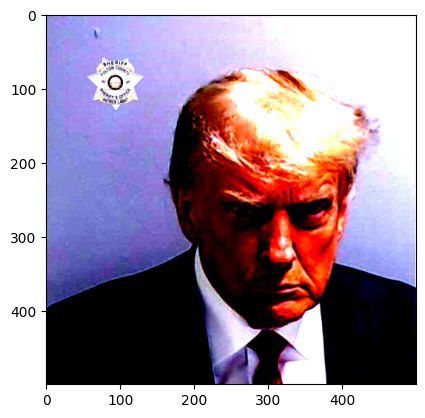

In [8]:
content = transform(content_image).to(device)
plt.imshow(content.cpu().permute(1,2,0))

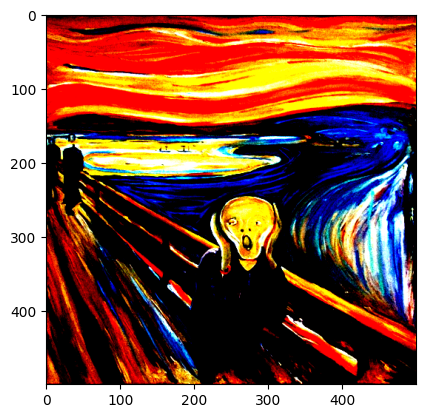

In [9]:
style = transform(style_image).to(device)  # Apply transforms
plt.imshow(style.cpu().permute(1,2,0))

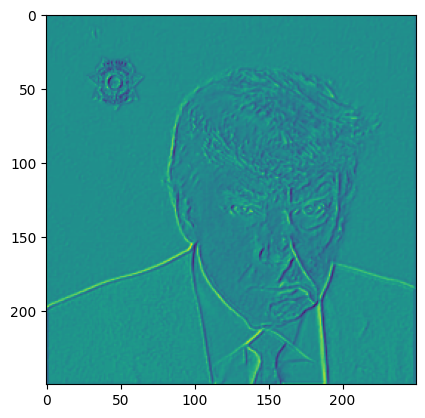

In [10]:
# layer 0,5,... (dictionary)
output,activations_layers = vgg(content)

# select layer 5
layer5 = activations_layers[5]

# select layer 5, 3rd channel
plt.imshow(layer5[3].cpu().detach())
#plt.imshow(output[0].cpu().detach().permute(1,2,0))

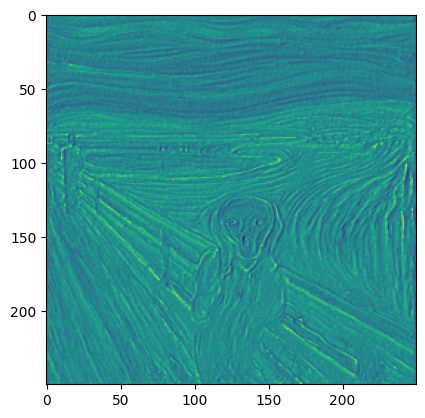

In [11]:
# layer 0,5,... (dictionary)
output,activations_layers = vgg(style)

# select layer 5
layer5 = activations_layers[5]

# select layer 5, 3rd channel
plt.imshow(layer5[3].cpu().detach())
#plt.imshow(output[0].cpu().detach().permute(1,2,0))

In [12]:
def get_gram_matrix(feature_maps):

  num_channels,h,w = feature_maps.shape

  feature_matrix = feature_maps.reshape(num_channels,h*w)
  gram_matrix = feature_matrix @ feature_matrix.T

  return gram_matrix 

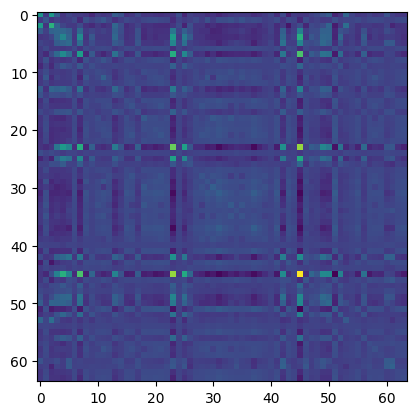

In [13]:
output,activations_layers = vgg(content)
feature_maps = activations_layers[0]
gram_matrix = get_gram_matrix(feature_maps)
plt.imshow(gram_matrix.cpu().detach())

In [14]:
epochs = 1000
loss_fn = nn.MSELoss()
activations_layers = [0,5,10,19,28]


vgg.to(device)
content = content.to(device)
style = style.to(device)

# Freeze VGG network
for param in vgg.parameters():
    param.requires_grad_(False)

# Initialize target image
combined = torch.randn(size=content.shape, dtype=torch.float32, device=device)

# For better Performance, use content
target = nn.Parameter(combined.clone().detach().to(device))  # Move to device
optimiser = torch.optim.Adam(params=[target], lr=0.2)

content_output, content_layers = vgg(content)
oof, style_layers = vgg(style)

for epoch in tqdm(range(epochs)):

    # Forward pass
    target_output, target_layers = vgg(target)
    
    # Calculate losses
    style_loss = 0
    #content_loss = loss_fn(content_output, target_output) 
    content_loss = F.mse_loss(content_output, target_output)
    
    for layer in activations_layers:
        c, h, w = style_layers[layer].shape
        G_style = get_gram_matrix(style_layers[layer])
        G_target = get_gram_matrix(target_layers[layer])
        style_loss += 1/5 * F.mse_loss(G_style, G_target) / (4 * (c**2) * (h * w)**2)
    
    total_loss = 10000000 * style_loss +  content_loss 
    #total_loss = content_loss
    if epoch % 50 == 0:
        print(total_loss)
    
    optimiser.zero_grad()
    total_loss.backward()
    optimiser.step()


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(3572.3079, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 56/1000 [00:03<00:45, 20.75it/s]

tensor(44.3927, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 106/1000 [00:05<00:42, 20.80it/s]

tensor(17.9235, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 156/1000 [00:08<00:40, 20.76it/s]

tensor(13.5770, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 206/1000 [00:11<00:38, 20.82it/s]

tensor(11.0947, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 256/1000 [00:13<00:35, 20.78it/s]

tensor(9.2507, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 306/1000 [00:16<00:33, 20.82it/s]

tensor(7.9216, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 356/1000 [00:18<00:30, 20.78it/s]

tensor(7.0126, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 406/1000 [00:21<00:28, 20.79it/s]

tensor(6.3670, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 456/1000 [00:23<00:26, 20.80it/s]

tensor(5.8795, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 506/1000 [00:26<00:23, 20.77it/s]

tensor(5.4918, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 556/1000 [00:29<00:21, 20.78it/s]

tensor(5.1670, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 606/1000 [00:31<00:18, 20.80it/s]

tensor(4.8894, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 656/1000 [00:34<00:16, 20.79it/s]

tensor(4.6473, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 706/1000 [00:36<00:14, 20.78it/s]

tensor(4.4355, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 756/1000 [00:39<00:11, 20.81it/s]

tensor(4.2485, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 806/1000 [00:42<00:09, 20.80it/s]

tensor(4.0823, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 856/1000 [00:44<00:06, 20.81it/s]

tensor(3.9355, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 906/1000 [00:47<00:04, 20.82it/s]

tensor(3.8083, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 956/1000 [00:49<00:02, 20.78it/s]

tensor(3.6932, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 1000/1000 [00:52<00:00, 19.22it/s]


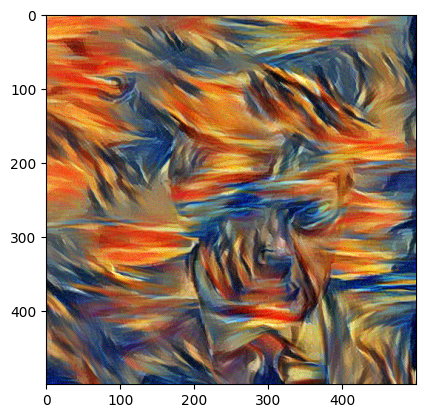

In [15]:
denormalization = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
img = target.clone().squeeze()
img = denormalization(img).clamp(0, 1)
plt.imshow(img.cpu().detach().permute(1,2,0))

In [16]:
epochs = 20
loss_fn = nn.MSELoss()
activations_layers = [0,5,10,19,28]

# Freeze VGG network
for param in vgg.parameters():
    param.requires_grad_(False)

# Initialize target image
combined = torch.randn(size=content.shape, dtype=torch.float32, device=device)

# For better Performance, use content
target = nn.Parameter(combined.clone().detach().to(device))  # Move to device
optimiser = torch.optim.LBFGS([target], lr=1, max_iter=20, history_size=100)

_, style_layers = vgg(style)
content_output, content_layers = vgg(content)

def closure():
    optimiser.zero_grad()
    
    # Forward pass
    target_output, comb_layers = vgg(target)
    
    # Calculate losses
    style_loss = 0
    content_loss = loss_fn(content_output, target_output)
    
    for layer in activations_layers:
        c, h, w = style_layers[layer].shape
        G_style = get_gram_matrix(style_layers[layer].detach())
        G_comb = get_gram_matrix(comb_layers[layer])
        style_loss += (1/5) * loss_fn(G_style, G_comb) / (4 * c**2 * (h*w)**2)
    
    total_loss = 10000000 * style_loss +  content_loss 
    
    # Backward pass
    total_loss.backward()
    
    return total_loss

train_loss_values = []

for epoch in tqdm(range(epochs)):
    # L-BFGS requires a closure function that recomputes the loss
    loss = optimiser.step(closure)
    train_loss_values.append(loss.item())
    print(f"Epoch {epoch}, Loss: {loss.item()}")

  5%|▌         | 1/20 [00:01<00:21,  1.15s/it]

Epoch 0, Loss: 3525.357177734375


 10%|█         | 2/20 [00:02<00:20,  1.13s/it]

Epoch 1, Loss: 36.677310943603516


 15%|█▌        | 3/20 [00:03<00:19,  1.14s/it]

Epoch 2, Loss: 15.102228164672852


 20%|██        | 4/20 [00:04<00:18,  1.17s/it]

Epoch 3, Loss: 11.007984161376953


 25%|██▌       | 5/20 [00:05<00:18,  1.20s/it]

Epoch 4, Loss: 7.940993309020996


 30%|███       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 6.117526054382324


 35%|███▌      | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 5.114048480987549


 40%|████      | 8/20 [00:09<00:15,  1.26s/it]

Epoch 7, Loss: 4.4483256340026855


 45%|████▌     | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 3.9520204067230225


 50%|█████     | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 3.6161623001098633


 55%|█████▌    | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 3.385063409805298


 60%|██████    | 12/20 [00:14<00:10,  1.27s/it]

Epoch 11, Loss: 3.224703311920166


 65%|██████▌   | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 3.099853992462158


 70%|███████   | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 2.9969098567962646


 75%|███████▌  | 15/20 [00:18<00:06,  1.27s/it]

Epoch 14, Loss: 2.9160637855529785


 80%|████████  | 16/20 [00:19<00:05,  1.27s/it]

Epoch 15, Loss: 2.850721597671509


 85%|████████▌ | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 2.793520450592041


 90%|█████████ | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 2.744432210922241


 95%|█████████▌| 19/20 [00:23<00:01,  1.27s/it]

Epoch 18, Loss: 2.7032294273376465


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]

Epoch 19, Loss: 2.666720151901245


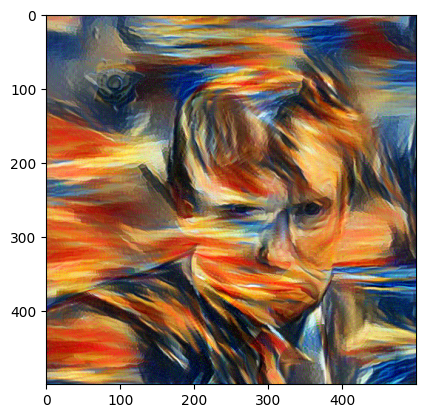

In [17]:
denormalization = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
img = target.clone().squeeze()
img = denormalization(img).clamp(0, 1)
plt.imshow(img.cpu().detach().permute(1,2,0))

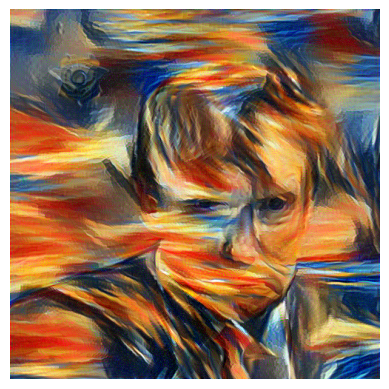

In [18]:
plt.imshow(img.cpu().detach().permute(1, 2, 0)) 
plt.axis("off")  # Hide axis  
plt.savefig("output_image.png", bbox_inches="tight", pad_inches=0)  # Save image  